#やりたいこと流れ  


今分かっていないこと  
・条件付き確率分布にvarを入れるべきかどうか  解決！  
・ギブスサンプリングの中はmuを入れるべきか  いらなさそう    
・ランジュバンの提案分布はGRBMとCRBMで変えないといけないのか  

今分かってること  
・torch_randn は np.random.randnと同じ  
・x@A / y@W / x@B / h@W.T / (h@W.T)*y  
・v0  ⇒ p(h0) ⇒ p(v1) ⇒ p(h1)のように、CD法を行ってます。  
これを v0 ⇒ p(h0) ⇒ h0 ⇒ p(v1) ⇒ v1 ⇒ p(h1)
のように、ちゃんとh0h0をサンプリングしてからp(v1)を算出すれば学習もちゃんと進みます。  
・同じ行列の形での計算は可能 例：(100,1)*(100,1)  
・((y-a-A*x)^2/(2z^2) - Wyh/z - (b+Bx)h)  
・(100,)-(100,1) = (100,100)  

指標  
・RMSE, MAE が 0 に近いほど見積もられる予測誤差が小さい、すなわち予測精度が高いことを表します。  
・R^2 は (yobs,i)と (ypred,i) が完全に一致する場合に 1 となり、1 に近いほど精度の高い予測が行えていることを表します。

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import warnings
warnings.simplefilter('ignore')
import seaborn as sns
sns.set()
import os
import re
from scipy import signal
import math
!pip install japanize_matplotlib
import japanize_matplotlib

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


#ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from natsort import natsorted

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=9cabe00c987fa4e3b87e48f9d48b2712c9b048cafb75d2ebfd7c784af9a9488f
  Stored in directory: /root/.cache/pip/wheels/4f/ca/96/4cc5e192421cceb077fbf4ffec533382edd416fd3fa0af0bbd
Successfully built japanize_matplotlib
Mounted at /content/drive


(0.0, 1.0, 0.0, 25.0)

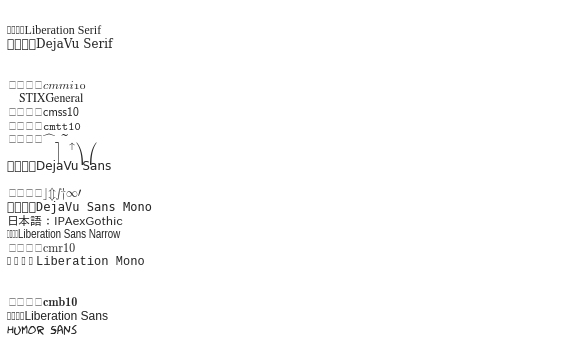

In [ ]:
import matplotlib
# フォントを全て読み込み
fonts = set([f.name for f in matplotlib.font_manager.fontManager.ttflist])
 
# 描画領域のサイズ調整
plt.figure(figsize=(10,len(fonts)/4))
 
# フォントの表示
for i, font in enumerate(fonts):
    plt.text(0, i, f"日本語：{font}", fontname=font)
    
# 見やすいように軸を消す
plt.ylim(0, len(fonts))
plt.axis("off")
    

#関数定義

##CRBM定義

In [ ]:
from ast import Call
from collections.abc import Callable
class CRBM(object):

    def __init__(self,
                x_data = None,
                y_data = None,
                A = None, 
                B = None, 
                W = None, 
                hbias = None, 
                vbias = None,
                log_var = None,
                input_dim = 1,
                n_hidden = 100,
                delay = 6,
                CD_step=1,
                init_var=1e-0,                 
                inference_method='Gibbs',
                Langevin_step=10,
                Langevin_eta=1.0,
                is_anneal_Langevin=True,
                Langevin_adjust_step=0) -> None:

        assert inference_method in ['Gibbs', 'Langevin', 'Gibbs-Langevin']

        
        self.n_hidden = n_hidden # 隠れ層のユニット数
        self.CD_step = CD_step
        self.inference_method = inference_method
        self.Langevin_step = Langevin_step
        self.Langevin_eta = Langevin_eta
        self.is_anneal_Langevin = is_anneal_Langevin
        self.Langevin_adjust_step = Langevin_adjust_step
        self.x_data = x_data
        self.y_data = y_data
        self.input_dim = input_dim  # 入力層データの次元数
        self.delay = delay # 遡るデータ数

        #パラメータを初期化する
        if A is None: # [入力層-出力層] 間の重みの初期化
            A = np.array(np.random.normal(loc=0.0, scale=0.01, size = (input_dim * delay, input_dim)))
        
        if B is None: # [入力層-隠れ層] 間の重みの初期化
            B = np.array(np.random.normal(loc=0.0, scale=0.01, size = (input_dim * delay, n_hidden))) #(750,20)

        if W is None: # [出力層-隠れ層] 間の重みの初期化
            W = np.array(np.random.normal(loc=0.0, scale=0.01, size = (input_dim, n_hidden))) #(1,20)
        
        if hbias is None: # 隠れ層のバイアスの初期化
            hbias = np.zeros((input_dim, n_hidden)) #(1,20)
        
        if vbias is None: # 出力層のバイアスの初期化
            vbias = np.zeros((input_dim, input_dim)) #(1,1)

        if log_var is None: # 分散の初期化
            log_var = np.zeros((input_dim, input_dim)) #log 1 = 0 #(1,1)
        
        # インスタンス変数の作成
        self.y_data = y_data
        self.x_data = x_data
        self.A = A
        self.B = B
        self.W = W
        self.hbias = hbias
        self.vbias = vbias
        self.log_var = log_var

    def reset_param(self,input_dim,delay,n_hidden):
          A       = np.array(np.random.normal(loc=0.0, scale=0.01, size = (input_dim * delay, input_dim)))
          B       = np.array(np.random.normal(loc=0.0, scale=0.01, size = (input_dim * delay, n_hidden))) #(750,20)
          W       = np.array(np.random.normal(loc=0.0, scale=0.01, size = (input_dim, n_hidden)))
          hbias   = np.zeros((input_dim, n_hidden))
          vbias   = np.zeros((input_dim, input_dim))
          log_var = np.zeros((input_dim, input_dim))
        
          # インスタンス変数の作成
          self.A       = A
          self.B       = B
          self.W       = W
          self.hbias   = hbias
          self.vbias   = vbias
          self.log_var = log_var
       

    #学習の全体アルゴリズム
    def CD_grad(self, lr, num_steps = 5, y_data = None, x_data = None):

        if y_data is not None: # 出力層のデータ
            self.y_data = y_data

        if x_data is not None: # 入力層のデータ
            self.x_data = x_data

        # postive gradient(ポジティブフェーズ)
        h_pos = self.positive_phase(self.x_data, self.y_data) #  ①

        # negative gradient(ネガティブフェーズ)
        v_neg, h_neg = self.negative_phase(h_pos, self.y_data)#　②

        ### 重みをバッチサイズで割るかどうか ###
        C = v_neg.shape[0]

        ### 分散を1に固定するかどうか ###
        var = self.get_var()

        vbi   = np.mean((self.y_data - v_neg)/(var**2), axis=0)  #(100,1) -> (1,1)
        hbi   = np.mean(h_pos - h_neg, axis=0)                   #(100,20) -> (1,20)
        aa    = (self.x_data.T @ (self.y_data - v_neg))/(var**2) #(750,100)(100,1) = (750,1)    
        bb    = (self.x_data.T @ (h_pos - h_neg))                #(750,20)
        ww    = (self.y_data.T @ h_pos - v_neg.T @ h_neg)/var    #(1,100)(100,20) - (1,100)(100.20) 

        v11   = ((h_pos @ self.W.T)*self.y_data)/var 
        v12   = (self.y_data**2 - 2*(self.x_data@self.A)*self.y_data - 2*self.y_data*self.vbias)/(var**2)
        v21   = ((h_neg @ self.W.T)*v_neg)/var 
        v22   = (v_neg**2 - 2*(self.x_data@self.A)*v_neg - 2*v_neg*self.vbias)/(var**2)
        vv    = (v12 - v11) - (v22 - v21) 
        log_v = np.mean(vv, axis=0)

        aa = aa / C
        ww = ww / C
        bb = bb / C
        hbi = hbi
        vbi = vbi 
      
        #log_var = np.clip(log_var,1e-8,None)

        self.vbias += lr * vbi #(1,1)
        self.hbias += lr * hbi #(1,20)
        self.A     += lr * aa  #(750,1)
        self.B     += lr * bb  #(750,20)
        self.W     += lr * ww  #(1,20)
        self.log_var += lr * (log_v) #(1,1)       
        
        return self.vbias, self.hbias, self.A, self.B, self.W, self.log_var

    def get_var(self):
        return np.clip(np.exp(self.log_var),1e-8,None)

    def positive_phase(self, x, y): #ポジティブフェーズ　①
        pre_h = self.prob_h_given_v(y,x)  #  ④
        h = np.random.binomial(n=1, p=(pre_h), size=pre_h.shape)  # P(y|x) ④
        return h

    def negative_phase(self, h_pos, y_data): #ネガティブフェーズ　②

        var = self.get_var()
        var_mean = np.mean(var**2)

        if self.inference_method == 'Gibbs':#「ギブスサンプリング」でネガティブフェーズを計算する
            samples = self.Gibbs_sampling_vh(h = h_pos, num_steps = self.CD_step) #  ⑤
            samples = samples[-1]
            return samples

        elif self.inference_method == 'Gibbs-Langevin':
            samples = self.Gibbs_Langevin_sampling_vh(
                h = h_pos,
                y = y_data,
                num_steps=self.CD_step,
                num_steps_Langevin=self.Langevin_step,
                eta=self.Langevin_eta * var_mean ,
                is_anneal=self.is_anneal_Langevin,
                adjust_step=self.Langevin_adjust_step)
            return samples

    def prob_h_given_v(self, y, x): #  ④
        var = self.get_var()
        xx = (y/var) @ self.W + (x) @ self.B + self.hbias #(100,1)*(1,20) + (100,750)*(750,20) + (1,20)
        return 1.0 / (1.0 + np.exp(-xx)) # vw + c(hatt) #sigmoid(xx) -> 0<= sigmoid(xx) <= 1

    def prob_v_given_h(self, h, x): #  ⑥
        var = self.get_var()
        yy =  h @ self.W.T + (x) @ self.A + self.vbias # hW + b(hatt) 
        return  yy
        
    @torch.no_grad()
    def Gibbs_sampling_vh(self, h, num_steps=10):  #  ⑤
        phk = h
        std = self.get_var()
        samples = []
        
        for ii in range(num_steps):
          hk  = np.random.binomial(n=1, p=phk, size=phk.shape)
          pvk = self.prob_v_given_h(hk, self.x_data)
          vk  = np.random.randn(pvk.shape[0], pvk.shape[1]) * std + pvk
          phk = self.prob_h_given_v(vk, self.x_data)

        samples += [(vk, phk)]

        return samples

    def Gibbs_Langevin_sampling_vh(self,
                                   h ,
                                   y ,
                                   num_steps=10,
                                   num_steps_Langevin=10,
                                   eta=1.0e+0,
                                   is_anneal=True,
                                   adjust_step=0):
        eta_list = self.cosine_schedule(eta_max=eta, T=num_steps_Langevin)

        phk = self.prob_h_given_v(y, self.x_data)
        hk  = np.random.binomial(n=1, p=phk, size=phk.shape)

        #numpy -> tensor型
        v = torch.from_numpy(y).clone().to(torch.float64)
        h = torch.from_numpy(hk).clone().to(torch.float64)
        
        for ii in range(num_steps):
            v_old, h_old = v, h
            # backward sampling
            for jj in range(num_steps_Langevin):
                eta_jj = eta_list[jj] if is_anneal else eta
                grad_v = self.energy_grad_v(v, h) #  ⑧
                v = v - eta_jj * grad_v + torch.randn_like(v) * np.sqrt(eta_jj * 2) 

            # forward sampling
            v = v.cpu().detach().numpy().copy() #tensor -> numpy

            pre_h = self.prob_h_given_v(v , self.x_data)  #  ④
            h = np.random.binomial(n=1, p=(pre_h), size=pre_h.shape)

            h = torch.from_numpy(h).clone().to(torch.float64) #numpy -> tensor
            v = torch.from_numpy(v).clone().to(torch.float64)

            if ii >= adjust_step:
                tmp_u = torch.rand(v.shape[0]).to(v.device) # (100,1)
                # 提案分布を求める
                log_ratio = self.log_metropolis_ratio_Gibbs_Langevin(v_old, h_old, v, h, eta_list) #(100,100)
                ratio = torch.minimum(torch.ones_like(log_ratio), log_ratio.exp()) #(100,100)             
                v = v * (tmp_u < ratio).float().view(-1, 1) + v_old * (tmp_u >= ratio).float().view(-1, 1)  # v(100,1)
                h = h * (tmp_u < ratio).float().view(-1, 1) + h_old * (tmp_u >= ratio).float().view(-1, 1)  # h(100,20)
                #v , hをそのまんま使うのでは無く、割合に応じて使う.
        # Tensor > Numpy  /// https://take-tech-engineer.com/pytorch-tensor-ndarray-numpy/#toc4
        
        v = v.cpu().detach().numpy().copy()
        h = h.cpu().detach().numpy().copy()

        samples = [v, h]

        return samples

    @torch.no_grad()
    def log_metropolis_ratio_Gibbs_Langevin(self, v_old, h_old, v_new, h_new, eta_list): #  ⑨
        """ Metropolis-Hasting ratio of accepting the move from old to new state """
        B = v_old.shape[0]
        var  = self.get_var()
        var2 = var**2
 
        eng_diff = -self.energy(v_new, h_new) + self.energy(v_old, h_old)  #  ⑩
        # eng_diff = エネルギー差 / (100,)

        w1= torch.from_numpy(self.W).clone()
        h1= torch.from_numpy(self.hbias).clone()
        v_new_1 = v_new.cpu().detach().numpy().copy()
        v_old_1 = v_old.cpu().detach().numpy().copy()

        state_h_new = (v_new_1/var) @ self.W + self.x_data @ self.B + self.hbias 
        state_h_old = (v_old_1/var) @ self.W + self.x_data @ self.B + self.hbias #(100,1)(1,20) + (100,20)
        
        state_h_new = torch.from_numpy(state_h_new).clone()
        state_h_old = torch.from_numpy(state_h_old).clone()
        var_torch   = torch.squeeze(torch.from_numpy(var).clone(),dim=1)
        var2_torch  = torch.squeeze(torch.from_numpy(var2).clone(),dim=1)


        #目標と入力間のバイナリクロスエントロピーを測定する関数
        log_prob_h_given_v_new = -F.binary_cross_entropy_with_logits(state_h_old, h_old, reduction='none').sum(dim=1) #state_h_old と　h_oldが同じサイズでないといけない　
        #h_old = (100,20) // state_h_old = (100,20)
        log_prob_h_given_v_old = -F.binary_cross_entropy_with_logits(state_h_new, h_new, reduction='none').sum(dim=1)
        # ２つとも dim=1 より(100,1)

        eta = torch.tensor(eta_list).to(var_torch.device)  # shape K X 1 #[10]
        #print(eta.shape)
        beta_in = 1.0 - eta.unsqueeze(1) / (B*(var2_torch).unsqueeze(0))  # shape K X D #[10,1]
        #print(beta_in.shape)
        
        #指定した位置にサイズ1の次元を挿入するにはtorch.unsqueeze -> [2,3,4].unsqeeze(1) = [2,1,3,4]
        beta = torch.flip(torch.cumprod(torch.flip(beta_in, [0]), 0), [0])  # shape K X D #[10,1]
        #print(beta.shape)
        
        #flip -> tensor配列を上下左右反転させる // cumprod -> input次元 の の要素の累積積を返します
        beta = F.pad(beta, [0, 0, 0, 1], "constant", 1.0)  # shape (K+1) X D   #[11,1]     
        #print(beta.shape)
        
        #行列をパディングする
        va = (beta[1:] * eta.view(-1, 1)).sum(dim=0) / (B*(var2_torch))  # shape 1 X D #[1]
        tilde_sigma_sqrt = ((beta[1:]**2 * eta.view(-1, 1)).sum(dim=0)).sqrt()  # shape 1 X D #[1]
        #print(tilde_sigma_sqrt.shape)

        proposal_eng_new = - torch.pow((v_old - beta[0] * v_new - va * (h_new.mm(w1.T))) / (2 * tilde_sigma_sqrt), 2.0).sum(dim=1)
        proposal_eng_old = - torch.pow((v_new - beta[0] * v_old - va * (h_old.mm(w1.T))) / (2 * tilde_sigma_sqrt), 2.0).sum(dim=1)
        
        return eng_diff + proposal_eng_new - proposal_eng_old + log_prob_h_given_v_new - log_prob_h_given_v_old

    @torch.no_grad()
    def energy(self, v, h):  #  ⑩
        C = v.shape[0]
        var = self.get_var()

        v1 = v.cpu().detach().numpy().copy()
        h1 = h.cpu().detach().numpy().copy() 

        eng1 = 0.5*(((v1 - self.vbias - self.x_data @ self.A )**2)/(var**2)).sum(axis=1)
        eng2 = ((h1 @ self.W.T)*(v1)/var).sum(axis=1)
        eng3 = ((self.hbias + self.x_data @ self.B) * h1).sum(axis=1)  
        eng  = eng1 - eng2 - eng3
        eng = torch.from_numpy(eng).clone()
        return eng

    @torch.no_grad()
    def energy_grad_v(self, v, h): #  ⑧
        C = v.shape[0]  
        v1 = v.cpu().detach().numpy().copy()
        h1 = h.cpu().detach().numpy().copy()
        var = self.get_var()

        value1 = (v1 - self.vbias - self.x_data @ self.A)/(var**2)
        value2 = (h1 @ self.W.T)/var
        value  = (value1 - value2)
        value = torch.from_numpy(value).clone()
        return value

    @torch.no_grad()
    def marginal_energy(self, v):
        C = v.shape[0]
        var = self.get_var()
        v1 = v.cpu().detach().numpy().copy()

        eng1 = 0.5*(((v1 - self.vbias - self.x_data @ self.A )**2)/(var**2)).sum(axis=1)
        eng2 = (v1 @ self.W)/var + self.x_data @ self.B + self.hbias
        eng3 = (np.log(1 + np.exp(eng2))).sum(axis = 1)
 
        eng  = eng1 - eng3
        eng = torch.from_numpy(eng).clone()
        return eng 


    # 誤差関数
    def mean_squared_error(self, v, v_history):
        return np.sum((v - self.recon(v_history,k=5)) **2) 

    # 出力値の生成
    def recon(self, v_history, k=None, threshold=1e-3):
        v = np.zeros(self.input_dim)

        if k is None:
            k = 5
            
        for _ in range(k):
            h_mean = self.prob_h_given_v(v,v_history)
            nv = self.prob_v_given_h(h_mean, v_history)
            
            if np.abs(nv - v).all() < threshold:
                break
                
            v = nv
            
        return v

    def fit(self, x_data, y_data, batch_size, epochs, validation_split, learning_rate=1e-3):

        # 開始
        start_time = time.perf_counter()

        var_list = []

        costs = [] # 学習途中の誤差のログ
        cnt = 0
        last_cost = 0

        X_train, X_val, y_train, y_val = train_test_split(x_data,y_data,test_size=validation_split) # 学習データと検証データの分割
        val_num = X_val.shape[0]

        for i in tqdm(range(epochs+1)):

            # batch_size の数だけ学習データからサンプリング
            batch_mask = np.random.choice(X_train.shape[0], batch_size)
            X_batch = X_train[batch_mask]
            y_batch = y_train[batch_mask]

            # CD法による学習
            vbias, hbias, A, B, W, log_var = self.CD_grad(lr = learning_rate, num_steps = 5, y_data = y_batch, x_data = X_batch)

            var = np.exp(log_var)

            var_list.append(self.Norm(var)) 
            
            cost = self.mean_squared_error(y_val, X_val)/val_num
            costs.append(cost)
 
            if i%10==0:

              # validationデータに対する誤差が5回連続で増えると打ち切り
              if cost > last_cost :
                cnt = cnt+1
              else :
                cnt = 0 
              last_cost = cost

              if cnt >= 5:
                break
              print("{}epoch cost={}".format(i+1, cost))

        #figure()でグラフを表示する領域をつくり，figというオブジェクトにする．
        fig = plt.figure(figsize=(7,10))
        fig.subplots_adjust(wspace=0.4, hspace=0.4)

        #add_subplot()でグラフを描画する領域を追加する．引数は行，列，場所
        ax1 = fig.add_subplot(2, 1, 1)
        ax2 = fig.add_subplot(2, 1, 2)

        ax1.plot(costs)
        ax1.set_title("costs")
        ax1.set_ylabel("loss")
        ax1.set_xlabel("epoch")
        ax2.plot(var_list)
        ax2.set_title("variance")
        ax2.set_ylabel("variance")
        ax2.set_xlabel("epoch")

        # 終了
        end_time = time.perf_counter()
        
        # 経過時間を出力(秒)
        elapsed_time = end_time - start_time
        print(elapsed_time)

        print("method：{}".format(self.inference_method))
        print("Last 分散：{}".format(var_list[-1]))

    def Norm(self,grads):
      total_norm = 0

      # 勾配の2乗和を計算
      for grad in grads:
          total_norm += np.sum(grad**2)

      # 平方根を計算
      total_norm = np.sqrt(total_norm)
      #print(np.round(total_norm, 2))
      return total_norm

    def cosine_schedule(self, eta_min=0, eta_max=1, T=10):
      return [eta_min + (eta_max - eta_min) * (1+math.cos(tt * math.pi / T))/2 for tt in range(T)]

    def param(self):
        return self.A, self.B, self.W, self.hbias, self.vbias, self.log_var


In [ ]:
def standardize(data, mean=None, std=None):
  if mean is None:
    mean = np.nanmean(data)
  if std is None:
    std = np.nanstd(data)

  return (data-mean)/std, mean, std


def cut_off(data, length ,est_num):

  # data.shape = (epoch, step)
  # out_x.shape = ( ,length)
  # out_y.shape = ( ,1)
  est_num = est_num - 1 
  out_x = []
  out_y = []
  for j in range(data.shape[0]-length-est_num): #2560-15 = 2545
    out_x.append(data[j:j+length]) #length分のデータを保持
    out_y.append(data[j+length+est_num]) #lengthの時だけのデータを保持 #est_num = 0の時、次の値を予測する。
#j~j+length-1分のデータを使って(与えるデータ)lengthの時のデータを予測→out_yと比較する

  out_x = np.array(out_x).reshape(len(out_x),length)
  out_y = np.array(out_y).reshape(len(out_y),1)

  return out_x, out_y

In [ ]:
def interpolation(x0,y0,x1,y1,x):
    return y0 + (y1 - y0) * (x - x0) / (x1 - x0)

def interpolation2(x0,y0,x1,y1,x2,y2,x):
    dn1 = (x0-x1)*(x0-x2)
    dn2 = (x1-x2)*(x1-x0)
    dn3 = (x2-x0)*(x2-x1)
    return y0*(x-x1)*(x-x2)/dn1+y1*(x-x2)*(x-x0)/dn2+y2*(x-x0)*(x-x1)/dn3

def calc_interpolate(df,pitch,m):
    sigxm=np.zeros(m*pitch-(m-1))
    sigxm[0]=df["Bearing1"][0]
    sigxm[m*pitch-m]=df["Bearing1"][pitch-1]
    for i in range(1,m*pitch-m,1):
        if i%m==0:
            sigxm[i]=df["Bearing1"][int(i/m)]
        if i > m*pitch-(2*m+1):
            sigxm[i] = interpolation(int(i/m),df["Bearing1"][int(i/m)],int(i/m)+1,df["Bearing1"][int(i/m)+1],int(i/m)+(i%m)/m)
        else:
            sigxm[i] = interpolation2(int(i/m),df["Bearing1"][int(i/m)],int(i/m)+1,df["Bearing1"][int(i/m)+1],int(i/m)+2,df["Bearing1"][int(i/m)+2],int(i/m)+(i%m)/m)
    return sigxm        

#データの読み込み

##Bearing1_1

In [ ]:
path = "/content/drive/MyDrive/IEEE/Bearing1_1"
path2 = path + "/Bearing1_1"

file_dir=[]
for file in os.listdir(path2): #accのファイルだけを取ってくる
    if re.match('acc.*',file)!=None:
        file_dir.append(file)

print("len : " + str(len(file_dir)))
print(natsorted(file_dir))

file_dir = natsorted(file_dir)

len : 2803
['acc_00001.csv', 'acc_00002.csv', 'acc_00003.csv', 'acc_00004.csv', 'acc_00005.csv', 'acc_00006.csv', 'acc_00007.csv', 'acc_00008.csv', 'acc_00009.csv', 'acc_00010.csv', 'acc_00011.csv', 'acc_00012.csv', 'acc_00013.csv', 'acc_00014.csv', 'acc_00015.csv', 'acc_00016.csv', 'acc_00017.csv', 'acc_00018.csv', 'acc_00019.csv', 'acc_00020.csv', 'acc_00021.csv', 'acc_00022.csv', 'acc_00023.csv', 'acc_00024.csv', 'acc_00025.csv', 'acc_00026.csv', 'acc_00027.csv', 'acc_00028.csv', 'acc_00029.csv', 'acc_00030.csv', 'acc_00031.csv', 'acc_00032.csv', 'acc_00033.csv', 'acc_00034.csv', 'acc_00035.csv', 'acc_00036.csv', 'acc_00037.csv', 'acc_00038.csv', 'acc_00039.csv', 'acc_00040.csv', 'acc_00041.csv', 'acc_00042.csv', 'acc_00043.csv', 'acc_00044.csv', 'acc_00045.csv', 'acc_00046.csv', 'acc_00047.csv', 'acc_00048.csv', 'acc_00049.csv', 'acc_00050.csv', 'acc_00051.csv', 'acc_00052.csv', 'acc_00053.csv', 'acc_00054.csv', 'acc_00055.csv', 'acc_00056.csv', 'acc_00057.csv', 'acc_00058.csv', 'a

In [ ]:
name=['h','m','s','0.000001s','hori','verti']

  0%|          | 0/2803 [00:00<?, ?it/s]

shape：(2803,)


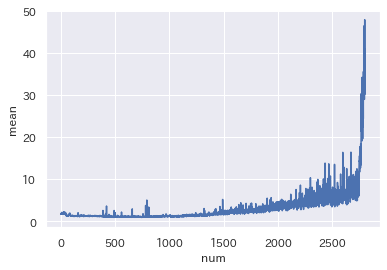

In [ ]:
mean = []

for i in tqdm(range(len(file_dir))):
  df=pd.read_csv(path2+'//'+file_dir[i],names=name)
  df_hori = df['hori'].abs()
  mean_hori = df_hori.nlargest(5).mean()
  mean.append(mean_hori)

plt.plot(mean)
plt.xlabel("num",fontname="IPAexGothic")
plt.ylabel("mean",fontname="IPAexGothic")

mean_np = np.array(mean)
print(f"shape：{mean_np.shape}")

##Bearing1_2

In [ ]:
path = "/content/drive/MyDrive/IEEE/Bearing1_2"
path2 = path + "/Bearing1_2"

file_dir=[]
for file in os.listdir(path2): #accのファイルだけを取ってくる
    if re.match('acc.*',file)!=None:
        file_dir.append(file)

print("len : " + str(len(file_dir)))
print(natsorted(file_dir))

file_dir = natsorted(file_dir)

len : 871
['acc_00001.csv', 'acc_00002.csv', 'acc_00003.csv', 'acc_00004.csv', 'acc_00005.csv', 'acc_00006.csv', 'acc_00007.csv', 'acc_00008.csv', 'acc_00009.csv', 'acc_00010.csv', 'acc_00011.csv', 'acc_00012.csv', 'acc_00013.csv', 'acc_00014.csv', 'acc_00015.csv', 'acc_00016.csv', 'acc_00017.csv', 'acc_00018.csv', 'acc_00019.csv', 'acc_00020.csv', 'acc_00021.csv', 'acc_00022.csv', 'acc_00023.csv', 'acc_00024.csv', 'acc_00025.csv', 'acc_00026.csv', 'acc_00027.csv', 'acc_00028.csv', 'acc_00029.csv', 'acc_00030.csv', 'acc_00031.csv', 'acc_00032.csv', 'acc_00033.csv', 'acc_00034.csv', 'acc_00035.csv', 'acc_00036.csv', 'acc_00037.csv', 'acc_00038.csv', 'acc_00039.csv', 'acc_00040.csv', 'acc_00041.csv', 'acc_00042.csv', 'acc_00043.csv', 'acc_00044.csv', 'acc_00045.csv', 'acc_00046.csv', 'acc_00047.csv', 'acc_00048.csv', 'acc_00049.csv', 'acc_00050.csv', 'acc_00051.csv', 'acc_00052.csv', 'acc_00053.csv', 'acc_00054.csv', 'acc_00055.csv', 'acc_00056.csv', 'acc_00057.csv', 'acc_00058.csv', 'ac

  0%|          | 0/871 [00:00<?, ?it/s]

shape：(871,)


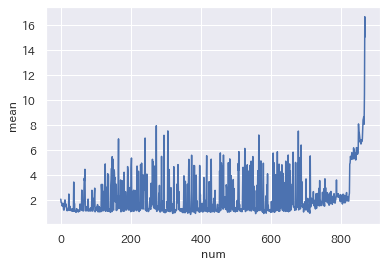

In [ ]:
mean2 = []

for i in tqdm(range(len(file_dir))):
  df=pd.read_csv(path2+'//'+file_dir[i],names=name)
  df_hori = df['hori'].abs()
  mean_hori = df_hori.nlargest(5).mean()
  mean2.append(mean_hori)

plt.plot(mean2)
plt.xlabel("num",fontname="IPAexGothic")
plt.ylabel("mean",fontname="IPAexGothic")

mean_np = np.array(mean2)
print(f"shape：{mean_np.shape}")

#データを補間する

In [ ]:
m = 1

In [ ]:
training_num  = []

df = pd.DataFrame(mean,columns=["Bearing1"])
pitch = len(df)
sigx2=calc_interpolate(df,pitch,m)
dfsigx2 = pd.DataFrame()
dfsigx2["sig"] = sigx2
print(dfsigx2)
data_df=dfsigx2['sig'].index.tolist() #数字を取得
Bearing1_data = (np.array(dfsigx2))
training_num.append(len(data_df))

          sig
0      1.8292
1      1.7000
2      1.7460
3      1.8518
4      1.6662
...       ...
2798  47.9104
2799  30.1900
2800  33.0360
2801  40.9830
2802  36.9390

[2803 rows x 1 columns]


In [ ]:
df = pd.DataFrame(mean2 ,columns=["Bearing1"])
pitch = len(df)
sigx2=calc_interpolate(df,pitch,m)
dfsigx2 = pd.DataFrame()
dfsigx2["sig"] = sigx2
print(dfsigx2)
data_df=dfsigx2['sig'].index.tolist() #数字を取得

Bearing2_data = (np.array(dfsigx2))
training_num.append(len(data_df))

training_num = np.array(training_num)

         sig
0     2.0676
1     1.7998
2     1.7796
3     1.7276
4     1.5178
..       ...
866   8.6790
867   8.0706
868  10.4814
869  16.6842
870  15.0746

[871 rows x 1 columns]


In [ ]:
print(training_num)
print(Bearing1_data.shape)

[2803  871]
(2803, 1)


#標準化

In [ ]:
delay = 15*m
est_num = 6*m #何点先を予測するか

In [ ]:
std_hori_data, hori_mean, hori_std = standardize(Bearing1_data)

hori_X, hori_y = cut_off(std_hori_data, delay,est_num)
size, delay = hori_X.shape
training_data_X = hori_X
training_data_y = hori_y.reshape(size,1)

In [ ]:
std_hori_data, hori_mean, hori_std = standardize(Bearing2_data)

hori_X, hori_y = cut_off(std_hori_data, delay,est_num)
size, delay = hori_X.shape
training_data_XX = hori_X
training_data_yy = hori_y.reshape(size,1)

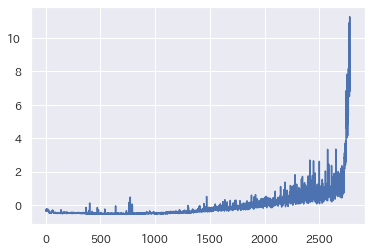

In [ ]:
plt.plot(training_data_y)

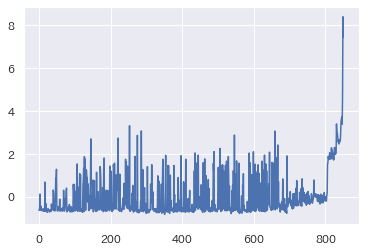

In [ ]:
plt.plot(training_data_yy)

In [ ]:
training_data_X =  np.vstack((training_data_X,training_data_XX))
training_data_y =  np.vstack((training_data_y,training_data_yy))

In [ ]:
print(training_data_y.shape)

(3634, 1)


##データを学習する

In [ ]:
lr = 1e-2
ep = 100
bs = 100*m

  0%|          | 0/101 [00:00<?, ?it/s]

1epoch cost=0.8791644753393286
11epoch cost=0.4113935374082827
21epoch cost=0.27374656515066365
31epoch cost=0.24592593767901055
41epoch cost=0.23692545097334955
51epoch cost=0.23150176517834814
61epoch cost=0.22965957430664194
71epoch cost=0.23643248381158996
81epoch cost=0.2306145938290085
91epoch cost=0.23319569861198916
101epoch cost=0.23773275816636327
0.2910711019999894
method：Gibbs
Last 分散：0.5944919133625719


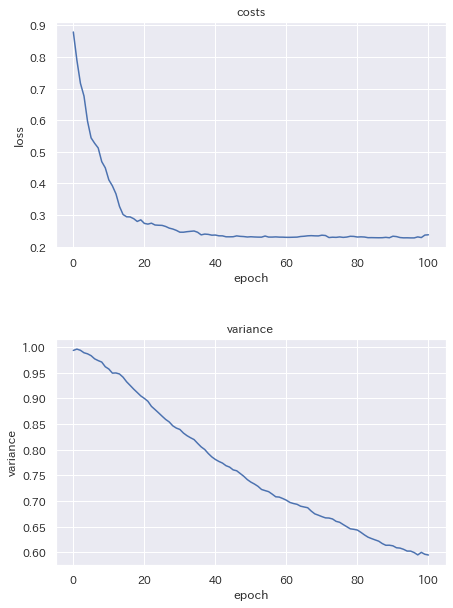

In [ ]:
crbm = CRBM(y_data=None,  
            x_data=None, 
            n_hidden=1, 
            input_dim=1, 
            CD_step = 1, 
            delay=delay)

crbm.fit(x_data=training_data_X, 
         y_data=training_data_y, 
         batch_size=bs, 
         epochs=ep, 
         validation_split = 0.1,
         learning_rate=lr)

In [ ]:
A, B, W, hbias, vbias, var= crbm.param()

##結果を表示

In [ ]:
seq_len  = training_data_y.shape[0]  # シーケンスの長さ
seq_len2 = training_data_yy.shape[0]
seq_num = training_num.shape[0] # シーケンスの個数

In [ ]:
print(training_data_y.shape)

(3634, 1)


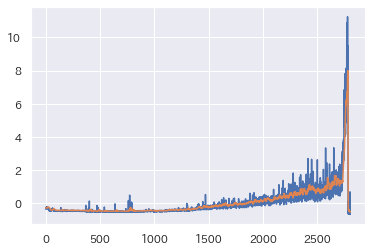

In [ ]:
fig = plt.figure()

#rand_seq = np.random.randint(0, seq_num) # ランダムなシーケンス番号
rand_seq  = 0

seq_X = training_data_X[rand_seq*seq_len : (rand_seq+1)*seq_len]
seq_y = training_data_y[rand_seq*seq_len : (rand_seq+1)*seq_len]
log_eval = [] 
log_ans = []
for i in range(seq_len):
  c_dist = crbm.recon(seq_X[i],5)
  log_eval.append(np.squeeze(c_dist))
  log_ans.append(seq_y[i])

plt.plot(log_ans)
plt.plot(log_eval)

  0%|          | 0/101 [00:00<?, ?it/s]

1epoch cost=0.5320178322084411
11epoch cost=0.17497911569346616
21epoch cost=0.1640734784882428
31epoch cost=0.16356815199797742
41epoch cost=0.16570024314320722
51epoch cost=0.1676830942364545
61epoch cost=0.1683687464862412
71epoch cost=0.17265160766428803
81epoch cost=0.16974660756535637
91epoch cost=0.1661912365792185
101epoch cost=0.1638074751640361
0.21396011999999587
method：Gibbs
Last 分散：0.6077389199521047
0.3348219115993091
0.8880845295967011
0.1532649576871373


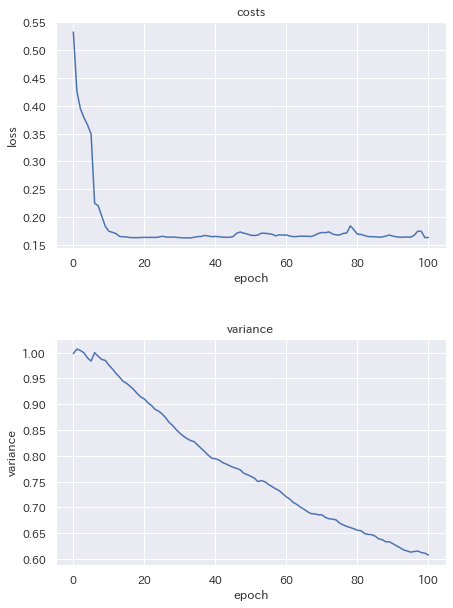

In [ ]:
crbm = CRBM(y_data=None,  
            x_data=None, 
            n_hidden=1, 
            input_dim=1, 
            CD_step = 5, 
            delay=delay)

crbm.fit(x_data=training_data_X, 
         y_data=training_data_y, 
         batch_size=bs, 
         epochs=ep, 
         validation_split = 0.1,
         learning_rate=lr)

#rand_seq = np.random.randint(0, seq_num) # ランダムなシーケンス番号
rand_seq  = 0

seq_X = training_data_X[rand_seq*seq_len : (rand_seq+1)*seq_len]
seq_y = training_data_y[rand_seq*seq_len : (rand_seq+1)*seq_len]
log_eval = [] 
log_ans = []

for i in range(seq_len):
  c_dist = crbm.recon(seq_X[i],5)
  log_eval.append(np.squeeze(c_dist))
  log_ans.append(seq_y[i])

rmse = np.sqrt(mean_squared_error(log_ans, log_eval))
print(rmse)

r2 = r2_score(log_ans, log_eval)
print(r2)


mae = mean_absolute_error(log_ans, log_eval)
print(mae)

0.8181372417350747
0.34302328562176987
0.5836025427286547


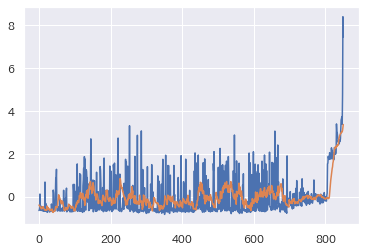

In [ ]:
fig = plt.figure()

#rand_seq = np.random.randint(0, seq_num) # ランダムなシーケンス番号

seq_X = training_data_XX[0 : seq_len2]
seq_y = training_data_yy[0 : seq_len2]
log_eval = [] 
log_ans = []

for i in range(seq_len2):
  c_dist = crbm.recon(seq_X[i],5)
  log_eval.append(np.squeeze(c_dist))
  log_ans.append(seq_y[i])

plt.plot(log_ans)
plt.plot(log_eval)

rmse = np.sqrt(mean_squared_error(log_ans, log_eval))
print(rmse)

r2 = r2_score(log_ans, log_eval)
print(r2)

mae = mean_absolute_error(log_ans, log_eval)
print(mae)


#langevin

  0%|          | 0/101 [00:00<?, ?it/s]

1epoch cost=1.084367344990282
11epoch cost=0.4310779518119106
21epoch cost=0.25859050435842806
31epoch cost=0.2535886084524734
41epoch cost=0.24950489490192793
51epoch cost=0.23059350907481432
61epoch cost=0.2429907822440907
71epoch cost=0.2537204790052796
81epoch cost=0.28109804413045114
91epoch cost=0.22214489892665112
101epoch cost=0.2357347637512034
0.31815869199999725
method：Gibbs-Langevin
Last 分散：0.5424032632938743
0.49172777163028647
0.7604341248660857
0.2567782995503923


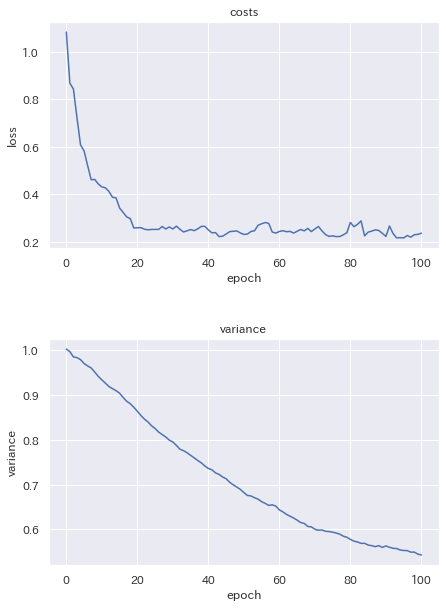

In [ ]:
crbm = CRBM(y_data=None, 
            x_data=None, 
            n_hidden=1, 
            input_dim=1, 
            delay=delay, 
            CD_step = 1,
            Langevin_step = 10,
            #Langevin_eta = 20.0,
            Langevin_adjust_step = 50,
            inference_method = 'Gibbs-Langevin')


crbm.fit(x_data = training_data_X, 
         y_data = training_data_y, 
         batch_size=bs, 
         epochs=ep, 
         validation_split = 0.1, 
         learning_rate=lr)

#rand_seq = np.random.randint(0, seq_num) # ランダムなシーケンス番号
rand_seq  = 0

seq_X = training_data_X[rand_seq*seq_len : (rand_seq+1)*seq_len]
seq_y = training_data_y[rand_seq*seq_len : (rand_seq+1)*seq_len]
log_eval = [] 
log_ans = []
for i in range(seq_len):
  c_dist = crbm.recon(seq_X[i],5)
  log_eval.append(np.squeeze(c_dist))
  log_ans.append(seq_y[i])

rmse = np.sqrt(mean_squared_error(log_ans, log_eval))
print(rmse)

r2 = r2_score(log_ans, log_eval)
print(r2)

mae = mean_absolute_error(log_ans, log_eval)
print(mae)

0.8196638925371406
0.34056915016475164
0.5893986418546155


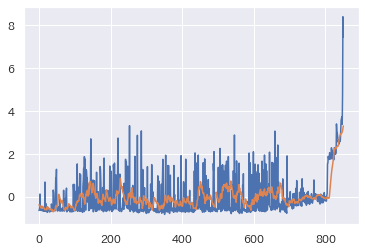

In [ ]:
fig = plt.figure()

#rand_seq = np.random.randint(0, seq_num) # ランダムなシーケンス番号

seq_X = training_data_XX[0 : seq_len2]
seq_y = training_data_yy[0 : seq_len2]
log_eval = [] 
log_ans = []
for i in range(seq_len2):
  c_dist = crbm.recon(seq_X[i],5)
  log_eval.append(np.squeeze(c_dist))
  log_ans.append(seq_y[i])

plt.plot(log_ans)
plt.plot(log_eval)

rmse = np.sqrt(mean_squared_error(log_ans, log_eval))
print(rmse)

r2 = r2_score(log_ans, log_eval)
print(r2)

mae = mean_absolute_error(log_ans, log_eval)
print(mae)

In [ ]:
print(training_data_X.shape)

(3634, 15)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(training_data_X,training_data_y,test_size=0.1) # 学習データと検証データの分割
val_num = X_val.shape[0]

(3270, 1)


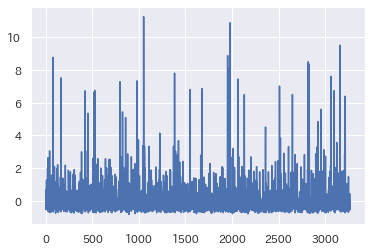

In [ ]:
plt.plot(y_train)
print(y_train.shape)

(364, 1)


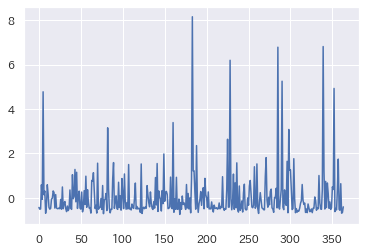

In [ ]:
plt.plot(y_val)
print(y_val.shape)

In [ ]:
batch_mask = np.random.choice(X_train.shape[0], bs)
print(batch_mask)

[1352  559 2198 2528 2139 2043  666 2948 1681 2160  544   67 1292  705
 2683 1903  990   51  976 2226 1904  560 1589 1779 2345 3004 1389  631
 2597 2030  510 2326 1117 1356 1643 3138  728 2082 1643 3155 3236  335
  809 2040 1500  418 2713  181 1798 3181  230  576 1370 2926 3247 3227
 2518  396  286 1378 2020  505 2651 2592 1010  387 2907 2789 1544  227
 1328 1387 2645 2833 2426  997 2341  627 2378  870  705 1047  961 2074
 1030  902 2951 1728  827 1788 2847   91  805 1368 1518 2705 3190 2393
  179 2972]


In [ ]:
y_batch = y_train[batch_mask]
print(y_batch)

[[-0.42537693]
 [-0.45668802]
 [ 0.60899503]
 [ 0.13299596]
 [-0.53629762]
 [-0.46890086]
 [-0.24535067]
 [-0.51227402]
 [-0.23570102]
 [-0.52524073]
 [-0.64806642]
 [-0.52906039]
 [ 1.89652428]
 [-0.22630267]
 [ 1.20775677]
 [-0.43934881]
 [-0.42673391]
 [-0.50051351]
 [ 1.17510774]
 [ 2.08944431]
 [ 1.65220543]
 [-0.32885878]
 [-0.55015282]
 [-0.51870712]
 [-0.05828822]
 [-0.41080194]
 [-0.51719936]
 [-0.3046711 ]
 [-0.48237016]
 [-0.46900138]
 [-0.61713409]
 [-0.42386917]
 [-0.50845437]
 [ 0.13078458]
 [-0.43271468]
 [-0.04838727]
 [-0.2352487 ]
 [-0.68504566]
 [-0.43271468]
 [-0.46543302]
 [-0.70097697]
 [ 1.15153646]
 [ 0.23044736]
 [ 0.33533703]
 [-0.68725512]
 [-0.46493043]
 [ 8.15421598]
 [-0.17408087]
 [ 0.18752653]
 [ 1.31660134]
 [-0.45407458]
 [-0.68190592]
 [-0.28791969]
 [-0.44683734]
 [ 0.16883033]
 [-0.34923517]
 [-0.15644323]
 [-0.41241021]
 [-0.51076626]
 [ 3.06067278]
 [ 0.5274756 ]
 [-0.48538568]
 [-0.50478549]
 [-0.431075  ]
 [ 0.56687833]
 [ 0.24085089]
 [-0.50895

In [ ]:
X_batch = []
y_batch = []

for i in range(ep + 1):
  X_train, X_val, y_train, y_val = train_test_split(training_data_X,training_data_y,test_size=0.1) # 学習データと検証データの分割
  val_num = X_val.shape[0]
  batch_mask = np.random.choice(X_train.shape[0], bs)
  X_batch.append(X_train[batch_mask])
  y_batch.append(y_train[batch_mask])

In [ ]:
y_batch_np = np.array(y_batch)
print(y_batch_np[0].shape)

(100, 1)
